In [98]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.sklearn   
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
%matplotlib inline

In [99]:
df = pd.read_csv('./moviereviewDATA_Sentiment_LabelAtEND.csv',encoding='utf-8')
df['CollapseText'] = df[df.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
all_texts = []
all_labels = []
for index in range(len(df)):
    data = df['CollapseText'][index]
    last_occ = data.rfind(',')
    data_prefix = data[0:last_occ-1]
    data_suffix = data[last_occ+1:]
    all_texts.append(data_prefix)
    all_labels.append(data_suffix)

new_df = pd.DataFrame()
new_df['TextValue'] = all_texts
new_df['ClassLabels'] = all_labels

print(new_df.head())

                                           TextValue ClassLabels
0  'plot : two teen couples go to a church party ...         neg
1  'the happy bastard\'s quick movie review \ndam...         neg
2  'it is movies like these that make a jaded mov...         neg
3  ' \" quest for camelot \" is warner bros . \' ...         neg
4  'synopsis : a mentally unstable man undergoing...         neg


Performing Cleaning of the Data.

In [100]:
def readandCleanData(string_value):
        stop_words = set(stopwords.words('english'))
        string_value.lstrip()
        string_value.rstrip()
        string_value.strip()
        file_arr = string_value.split(" ")
        new_file_contents = []
        for word in file_arr:
            word = word.lower()
            word = word.lstrip()
            word = word.strip("\n")
            word = word.replace(",","")
            word = word.replace(" ","")
            word = word.replace("_","")
            word = re.sub('\+', ' ',word)
            word = re.sub('.*\+\n', '',word)
            word = re.sub('zz+', ' ',word)
            word = word.replace("\t","")
            word = word.replace(".","")
            word = word.strip()
            word = word.replace("'\'","")
            if word not in ["", "\\", '"', "'", "*", ":", ";"]:
                if not re.search(r'\d', word):
                    if word not in stop_words:
                        new_file_contents.append(word)
            file_string_join = " ".join(new_file_contents)       
            file_string_join = file_string_join.replace("\\n","")
            file_string_join = file_string_join.strip("\\n")
            file_string_join = file_string_join.replace("\\'","")
            file_string_join = file_string_join.replace("\\","")
            file_string_join = file_string_join.replace('"',"")
            file_string_join = file_string_join.replace("'","")
            file_string_join = file_string_join.replace("s'","")
            file_string_join = file_string_join.lstrip()       
        return file_string_join 

In [101]:
all_cleaned_texts = []
columns = ['CleanTextValue','ClassLabels']
file_name = 'CleanDF_karandhir.csv'
for index in range(len(new_df)):
    clean_data = readandCleanData(new_df['TextValue'][index])
    all_cleaned_texts.append(clean_data)
new_df['CleanTextValue'] = all_cleaned_texts
new_df = new_df.drop('TextValue', axis=1)  
new_df.to_csv(file_name, mode='w',header=columns, index=False) 

Performing Lemmatization and Stemming

In [102]:
print(new_df.head(5))

  ClassLabels                                     CleanTextValue
0         neg  plot two teen couples go church party drink dr...
1         neg  the happy bastards quick movie review damn bug...
2         neg  it movies like make jaded movie viewer thankfu...
3         neg  quest camelot  warner bros  first feature-leng...
4         neg  synopsis mentally unstable man undergoing psyc...


In [103]:
negative_sentiment = new_df[new_df["ClassLabels"] == 'neg']
positive_sentiment = new_df[new_df["ClassLabels"] == 'pos']

In [104]:
def tfidfvectorizer(df_news,search) -> None:
    vectorizer = TfidfVectorizer(stop_words='english',max_features=50)
    X = vectorizer.fit_transform(df_news[search])
    column_names = vectorizer.get_feature_names_out()
    vectorized_text = pd.DataFrame(X.toarray(),columns=column_names)
    return vectorized_text,column_names

Word Cloud for Negative Labels

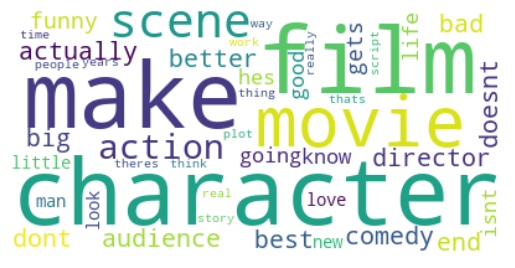

In [105]:
vectorized_text,column_names = tfidfvectorizer(negative_sentiment,'CleanTextValue')
text = " ".join(title for title in column_names)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Positive Labels

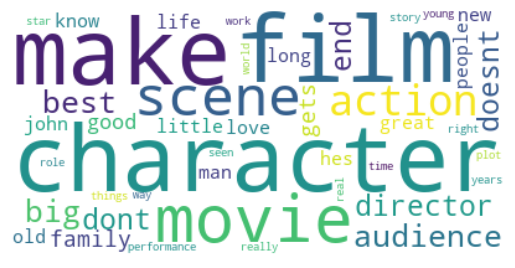

In [106]:
vectorized_text,column_names = tfidfvectorizer(positive_sentiment,'CleanTextValue')
text = " ".join(title for title in column_names)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [94]:

warnings.filterwarnings("ignore", category=DeprecationWarning)

def lemmatize_words(text):
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)

def stemming_words(text):
        ps = PorterStemmer()
        words = text.split()
        words = [ps.stem(word) for word in words]
        return ' '.join(words) 

new_df['CleanTextValue'] = new_df['CleanTextValue'].apply(lemmatize_words)
new_df['CleanTextValue'] = new_df['CleanTextValue'].apply(stemming_words) 
vectorizer = CountVectorizer(stop_words='english',max_features=50)
X = vectorizer.fit_transform(new_df['CleanTextValue'])
column_names = vectorizer.get_feature_names_out()
vectorized_df = pd.DataFrame(X.toarray(),columns=column_names)
num_topics = 7
lda_model_DH = LatentDirichletAllocation(n_components=num_topics, 
                                         max_iter=100, learning_method='online')
LDA_DH_Model = lda_model_DH.fit_transform(vectorized_df)
print("SIZE: ", LDA_DH_Model.shape) 

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic:  ", idx)  
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
print_topics(lda_model_DH, vectorizer, 15)
word_topic = np.array(lda_model_DH.components_)
word_topic = word_topic.transpose()
num_top_words = 15
vocab_array = np.asarray(column_names)
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model_DH, X, vectorizer)

SIZE:  (2000, 7)
Topic:   0
[('bad', 858.6116533939278), ('look', 528.1276845497149), ('act', 305.034856590912), ('like', 208.49462612809683), ('best', 11.241276427297226), ('stori', 7.641760526574659), ('movi', 7.555222674302812), ('say', 7.342138955529539), ('thi', 7.3163997929818105), ('role', 6.418681057293686), ('anoth', 5.891632475325077), ('want', 4.988282744217303), ('scene', 4.051242666200146), ('perform', 2.570891585144895), ('big', 1.7031796633601768)]
Topic:   1
[('life', 1397.5755726600446), ('stori', 1108.3202598279056), ('charact', 766.1602741580449), ('movi', 613.7441287222522), ('time', 491.6068535975048), ('work', 480.5353678400727), ('perform', 480.4496469034821), ('role', 426.34420953141534), ('play', 421.7032403202086), ('make', 407.5977041703796), ('film', 394.46313491941197), ('love', 354.4154732684484), ('director', 311.0146819289786), ('way', 306.35421603267685), ('come', 303.3887054924509)]
Topic:   2
[('movi', 5453.090457672268), ('like', 830.207295637203), (

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [107]:
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [115]:
max_features_1 = 30
vec_1 = CountVectorizer(stop_words='english')
vec_2 = CountVectorizer(stop_words='english',max_features = max_features_1)
vec_3 = CountVectorizer(stop_words='english')
new_df['cv_no_stopwords'] = vec_1.fit_transform(new_df['CleanTextValue']).toarray().tolist()
new_df['cv_max_features'] = vec_2.fit_transform(new_df['CleanTextValue']).toarray().tolist()
new_df['cv_lemmatized'] = vec_3.fit_transform(new_df['CleanTextValue'].apply(lemmatize_words)).toarray().tolist()

In [117]:
new_df_1 = new_df.loc[:, ['cv_no_stopwords', 'ClassLabels']]
new_df_2 = new_df.loc[:, ['cv_max_features', 'ClassLabels']]
new_df_3 = new_df.loc[:, ['cv_lemmatized', 'ClassLabels']]

In [118]:
X1 = new_df['cv_no_stopwords']
y1 = new_df['ClassLabels']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)
X2 = new_df['cv_max_features']
y2 = new_df['ClassLabels']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)
X3 = new_df['cv_lemmatized']
y3 = new_df['ClassLabels']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, stratify=y3, random_state=42)

Accuracy: 0.8175
Confusion matrix: [[163  37]
 [ 36 164]]


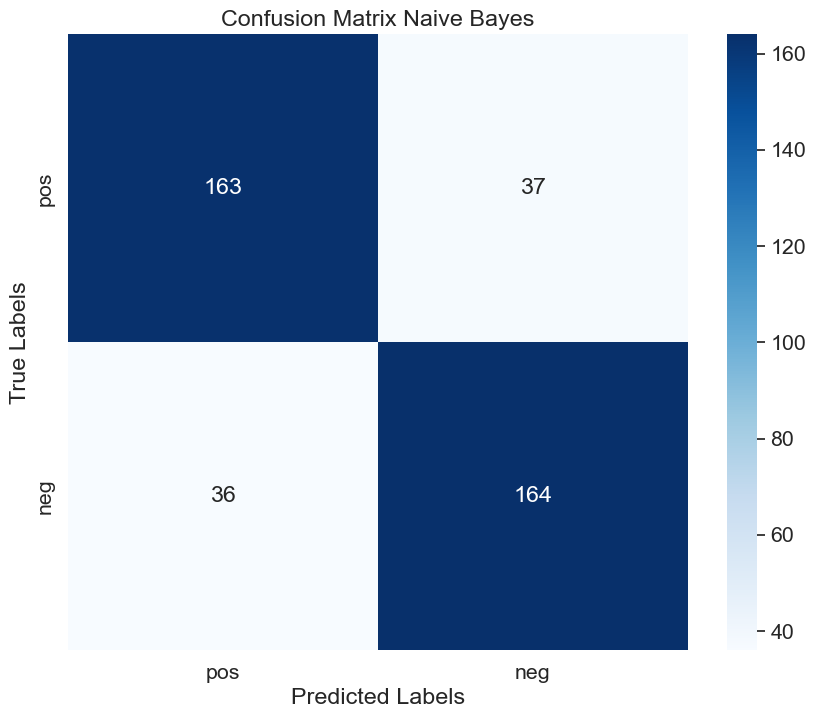

              precision    recall  f1-score   support

         neg       0.82      0.81      0.82       200
         pos       0.82      0.82      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [119]:

classifer_nb = MultinomialNB()
classifer_nb.fit(list(X_train1), y_train1)

predictions = classifer_nb.predict(list(X_test1))

accuracy = accuracy_score(y_test1, predictions)
print(f"Accuracy: {accuracy}")

confusion_mat = confusion_matrix(y_test1, predictions)
print(f"Confusion matrix: {confusion_mat}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=y_train1.unique(), yticklabels=y_train1.unique())

plt.title('Confusion Matrix Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test1, predictions))

Accuracy: 0.6825
Confusion matrix: [[131  69]
 [ 58 142]]


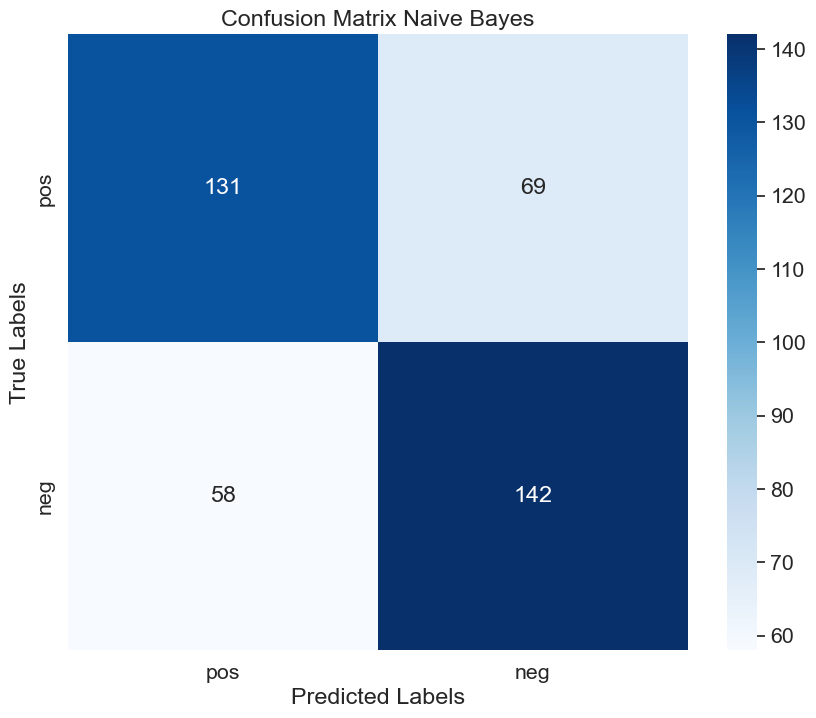

              precision    recall  f1-score   support

         neg       0.69      0.66      0.67       200
         pos       0.67      0.71      0.69       200

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



In [120]:

classifer_nb = MultinomialNB()
classifer_nb.fit(list(X_train2), y_train2)

predictions = classifer_nb.predict(list(X_test2))

accuracy = accuracy_score(y_test2, predictions)
print(f"Accuracy: {accuracy}")

confusion_mat = confusion_matrix(y_test2, predictions)
print(f"Confusion matrix: {confusion_mat}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=y_train2.unique(), yticklabels=y_train2.unique())

plt.title('Confusion Matrix Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test2, predictions))

Accuracy: 0.8133333333333334
Confusion matrix: [[247  53]
 [ 59 241]]


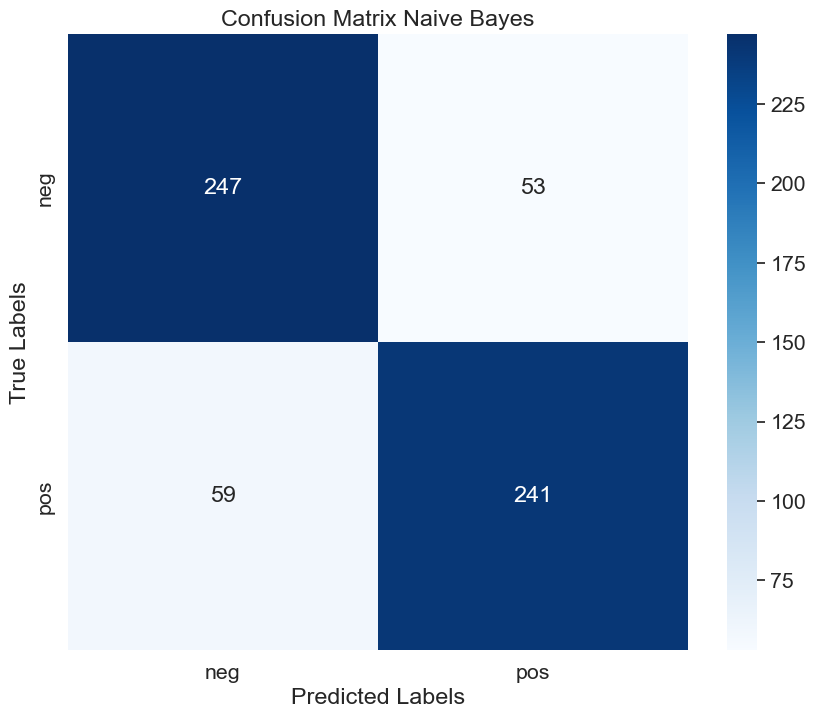

              precision    recall  f1-score   support

         neg       0.81      0.82      0.82       300
         pos       0.82      0.80      0.81       300

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600



In [121]:

classifer_nb = MultinomialNB()
classifer_nb.fit(list(X_train3), y_train3)

predictions = classifer_nb.predict(list(X_test3))

accuracy = accuracy_score(y_test3, predictions)
print(f"Accuracy: {accuracy}")

confusion_mat = confusion_matrix(y_test3, predictions)
print(f"Confusion matrix: {confusion_mat}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=y_train3.unique(), yticklabels=y_train3.unique())

plt.title('Confusion Matrix Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test3, predictions))

Accuracy(DT1): 0.6475
Confusion matrix(DT1): [[100 100]
 [ 41 159]]


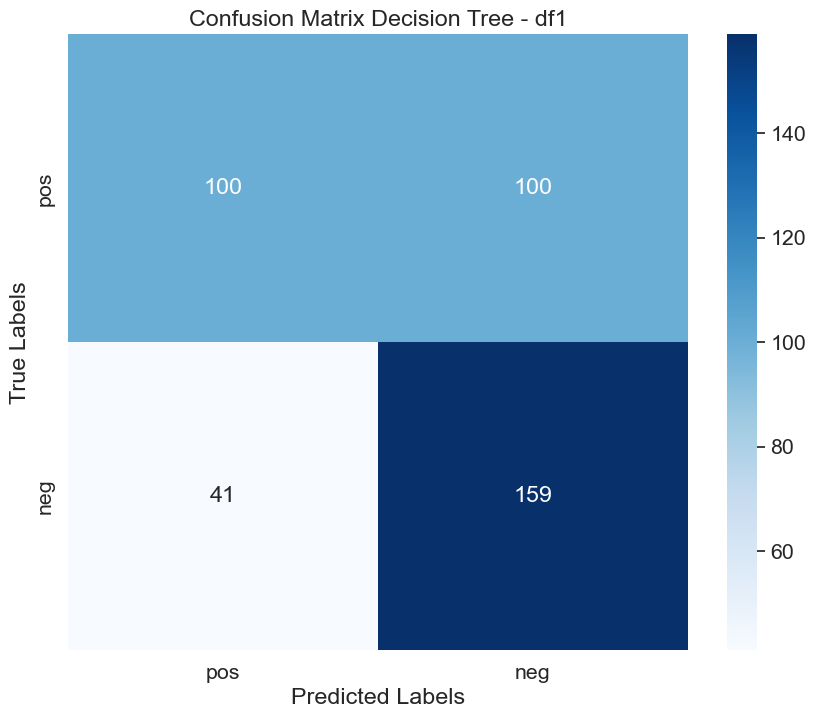

'tree1.png.pdf'

In [122]:

dt_classifier1 = DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=44)

dt_classifier1.fit(list(X_train1), y_train1)

predictions1 = dt_classifier1.predict(list(X_test1))

accuracy1 = accuracy_score(y_test1, predictions1)
print(f"Accuracy(DT1): {accuracy1}")

confusion_mat1 = confusion_matrix(y_test1, predictions1)
print(f"Confusion matrix(DT1): {confusion_mat1}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat1, annot=True, fmt='g', cmap='Blues', xticklabels=y_train1.unique(), yticklabels=y_train1.unique())


plt.title('Confusion Matrix Decision Tree - DF1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Tree
import graphviz
dot_data1 = tree.export_graphviz(dt_classifier1, out_file=None,class_names=y1.unique(), filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data1)
graph.render('tree1.png')

Accuracy(DT1): 0.61
Confusion matrix(DT1): [[116  84]
 [ 72 128]]


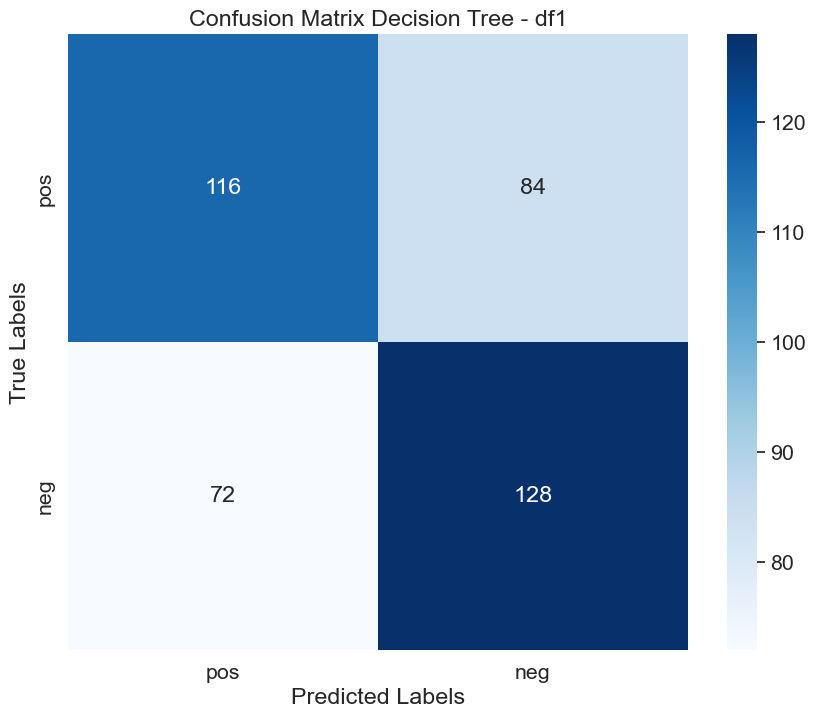

In [123]:

dt_classifier1 = DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=44)

dt_classifier1.fit(list(X_train2), y_train2)

predictions1 = dt_classifier1.predict(list(X_test2))

accuracy1 = accuracy_score(y_test2, predictions1)
print(f"Accuracy(DT1): {accuracy1}")

confusion_mat1 = confusion_matrix(y_test2, predictions1)
print(f"Confusion matrix(DT1): {confusion_mat1}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat1, annot=True, fmt='g', cmap='Blues', xticklabels=y_train2.unique(), yticklabels=y_train2.unique())


plt.title('Confusion Matrix Decision Tree - DF2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Accuracy(DT1): 0.5983333333333334
Confusion matrix(DT1): [[188 112]
 [129 171]]


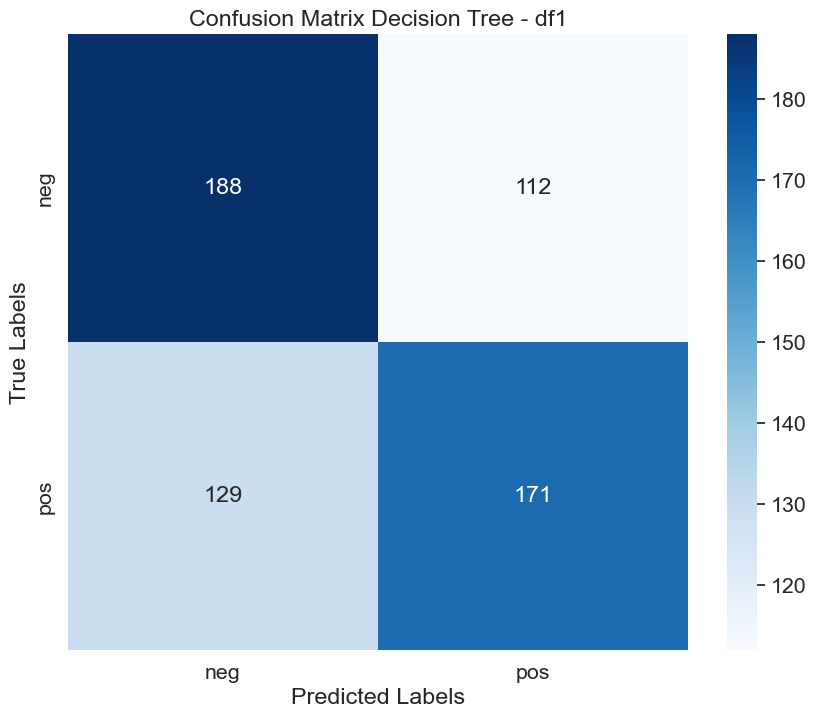

In [124]:

dt_classifier1 = DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=44)

dt_classifier1.fit(list(X_train3), y_train3)

predictions1 = dt_classifier1.predict(list(X_test3))

accuracy1 = accuracy_score(y_test3, predictions1)
print(f"Accuracy(DT1): {accuracy1}")

confusion_mat1 = confusion_matrix(y_test3, predictions1)
print(f"Confusion matrix(DT1): {confusion_mat1}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat1, annot=True, fmt='g', cmap='Blues', xticklabels=y_train3.unique(), yticklabels=y_train3.unique())


plt.title('Confusion Matrix Decision Tree - DF3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Linear kernel accuracy: 0.83
Linear kernel confusion matrix: [[163  37]
 [ 31 169]]


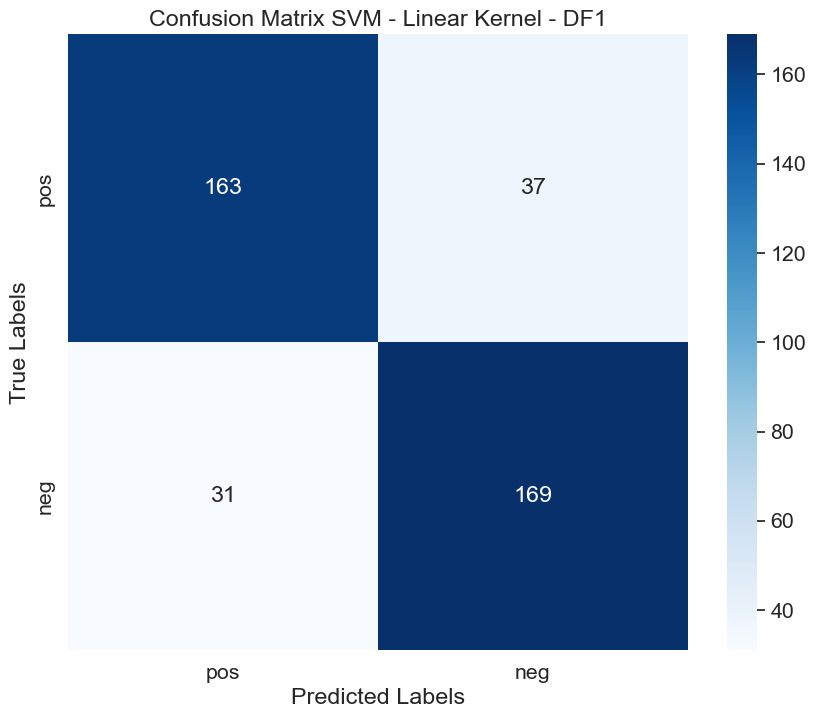

In [125]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(list(X_train1), y_train1)


predictions_linear = svm_classifier.predict(list(X_test1))


accuracy_linear = accuracy_score(y_test1, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test1, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train1.unique(), yticklabels=y_train1.unique())


plt.title('Confusion Matrix SVM - Linear Kernel - DF1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.685
Linear kernel confusion matrix: [[139  61]
 [ 65 135]]


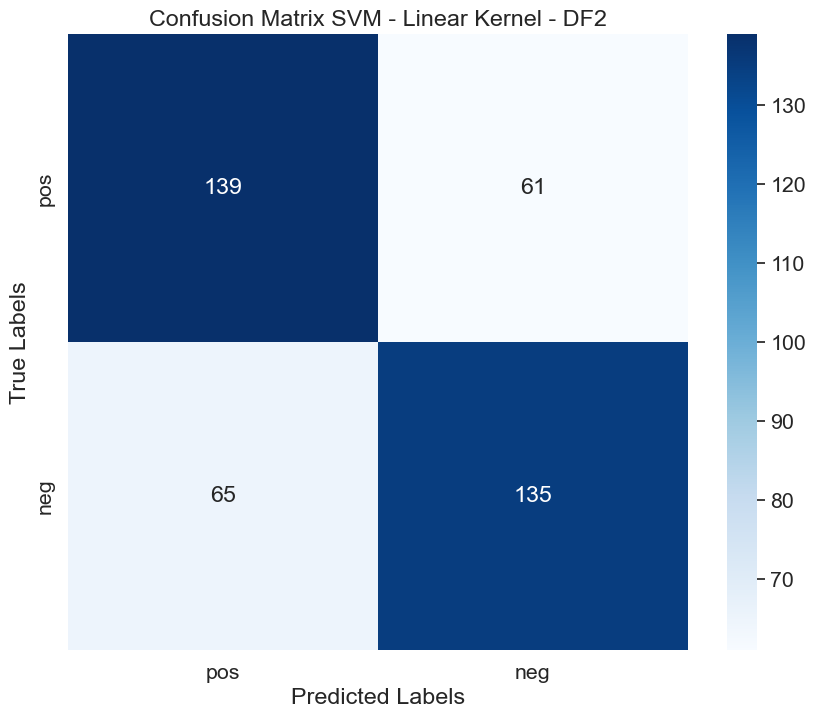

In [126]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(list(X_train2), y_train2)


predictions_linear = svm_classifier.predict(list(X_test2))


accuracy_linear = accuracy_score(y_test2, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test2, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train2.unique(), yticklabels=y_train2.unique())


plt.title('Confusion Matrix SVM - Linear Kernel - DF2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.81
Linear kernel confusion matrix: [[239  61]
 [ 53 247]]


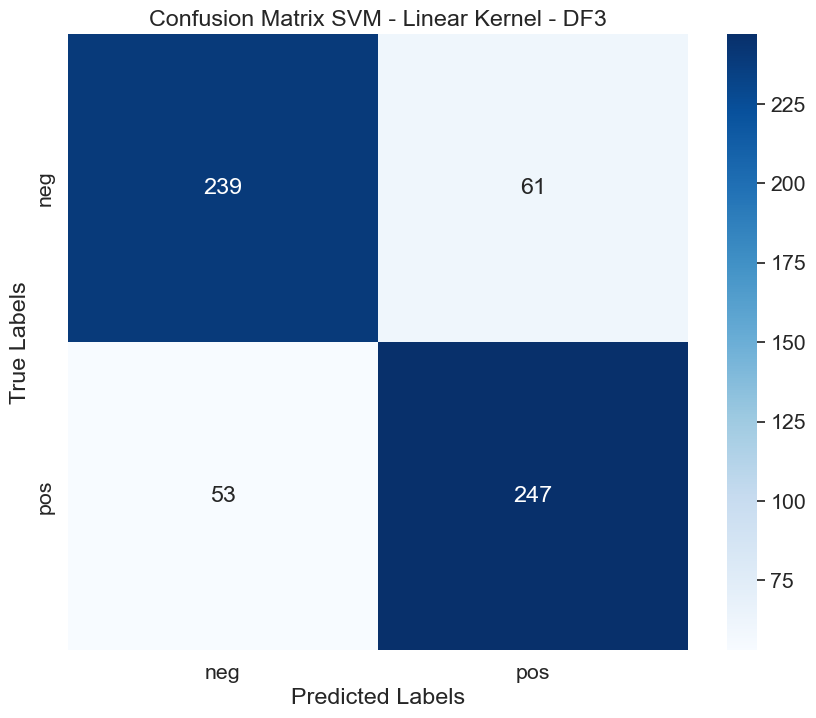

In [127]:

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(list(X_train3), y_train3)


predictions_linear = svm_classifier.predict(list(X_test3))


accuracy_linear = accuracy_score(y_test3, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test3, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train3.unique(), yticklabels=y_train3.unique())


plt.title('Confusion Matrix SVM - Linear Kernel - DF3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.57
Linear kernel confusion matrix: [[187  13]
 [159  41]]


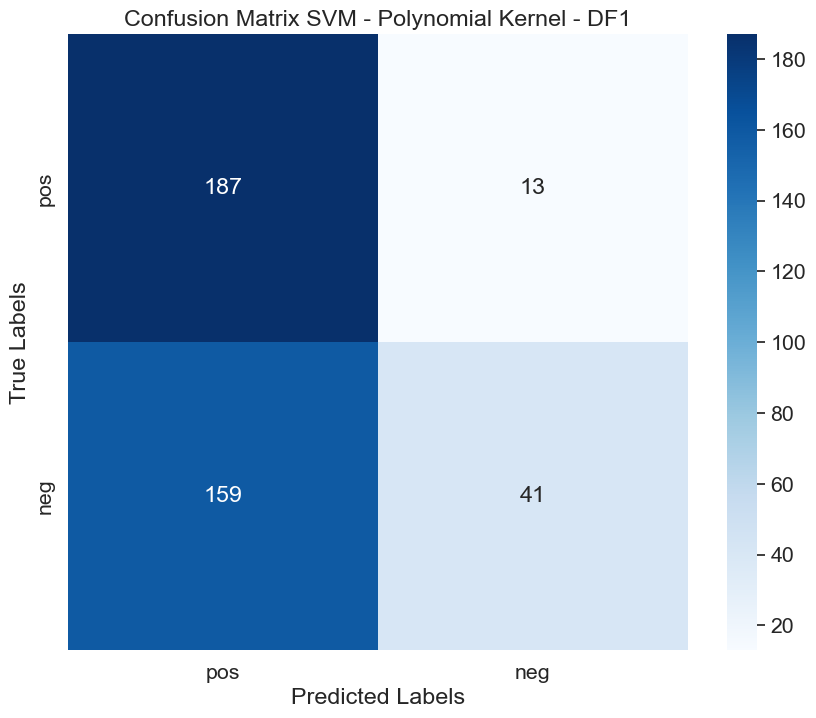

In [128]:

svm_classifier = SVC(kernel='poly')
svm_classifier.fit(list(X_train1), y_train1)


predictions_linear = svm_classifier.predict(list(X_test1))


accuracy_linear = accuracy_score(y_test1, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test1, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train1.unique(), yticklabels=y_train1.unique())


plt.title('Confusion Matrix SVM - Polynomial Kernel - DF1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.62
Linear kernel confusion matrix: [[160  40]
 [112  88]]


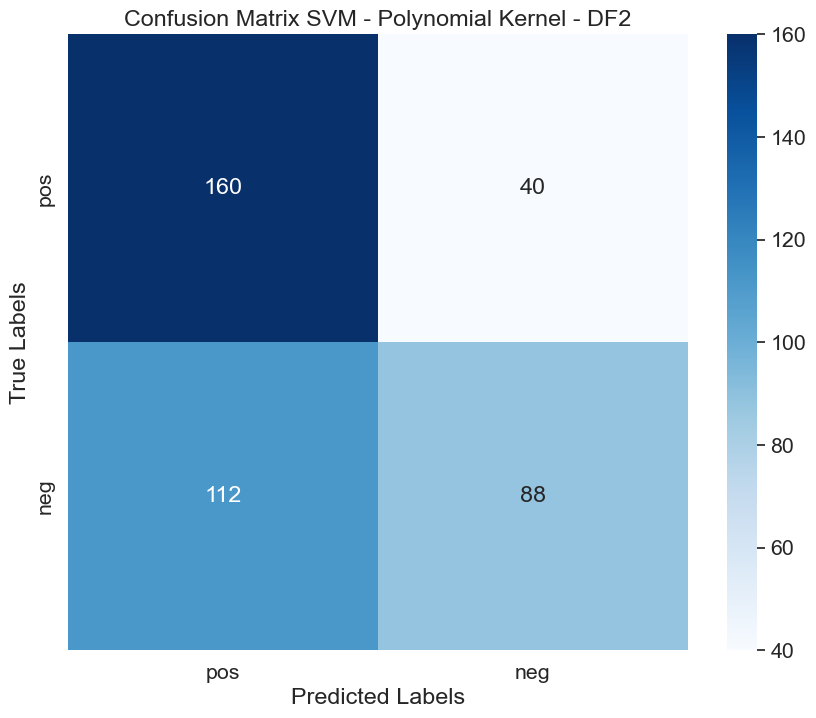

In [129]:

svm_classifier = SVC(kernel='poly')
svm_classifier.fit(list(X_train2), y_train2)


predictions_linear = svm_classifier.predict(list(X_test2))


accuracy_linear = accuracy_score(y_test2, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test2, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train2.unique(), yticklabels=y_train2.unique())


plt.title('Confusion Matrix SVM - Polynomial Kernel - DF2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.5866666666666667
Linear kernel confusion matrix: [[278  22]
 [226  74]]


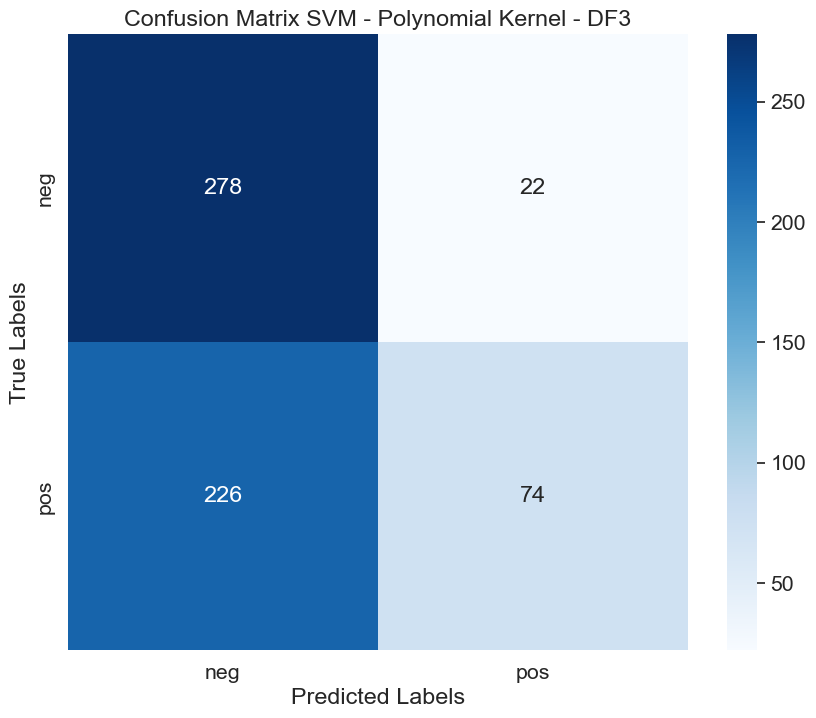

In [130]:

svm_classifier = SVC(kernel='poly')
svm_classifier.fit(list(X_train3), y_train3)


predictions_linear = svm_classifier.predict(list(X_test3))


accuracy_linear = accuracy_score(y_test3, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test3, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train3.unique(), yticklabels=y_train3.unique())


plt.title('Confusion Matrix SVM - Polynomial Kernel - DF3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.795
Linear kernel confusion matrix: [[158  42]
 [ 40 160]]


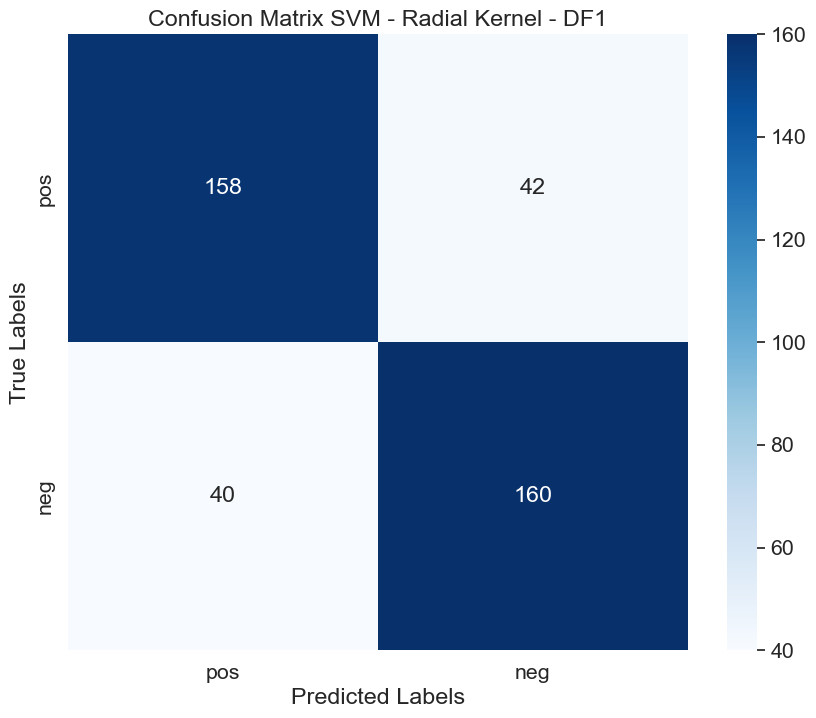

In [131]:

svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(list(X_train1), y_train1)


predictions_linear = svm_classifier.predict(list(X_test1))


accuracy_linear = accuracy_score(y_test1, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test1, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train1.unique(), yticklabels=y_train1.unique())


plt.title('Confusion Matrix SVM - Radial Kernel - DF1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.66
Linear kernel confusion matrix: [[135  65]
 [ 71 129]]


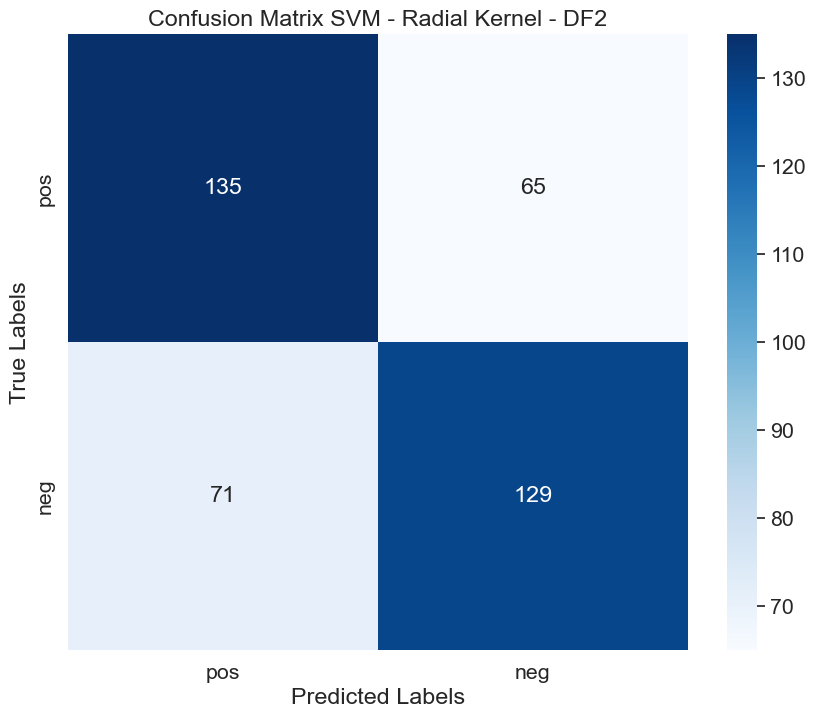

In [135]:

svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(list(X_train2), y_train2)


predictions_linear = svm_classifier.predict(list(X_test2))


accuracy_linear = accuracy_score(y_test2, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test2, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train2.unique(), yticklabels=y_train2.unique())


plt.title('Confusion Matrix SVM - Radial Kernel - DF2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Linear kernel accuracy: 0.7883333333333333
Linear kernel confusion matrix: [[236  64]
 [ 63 237]]


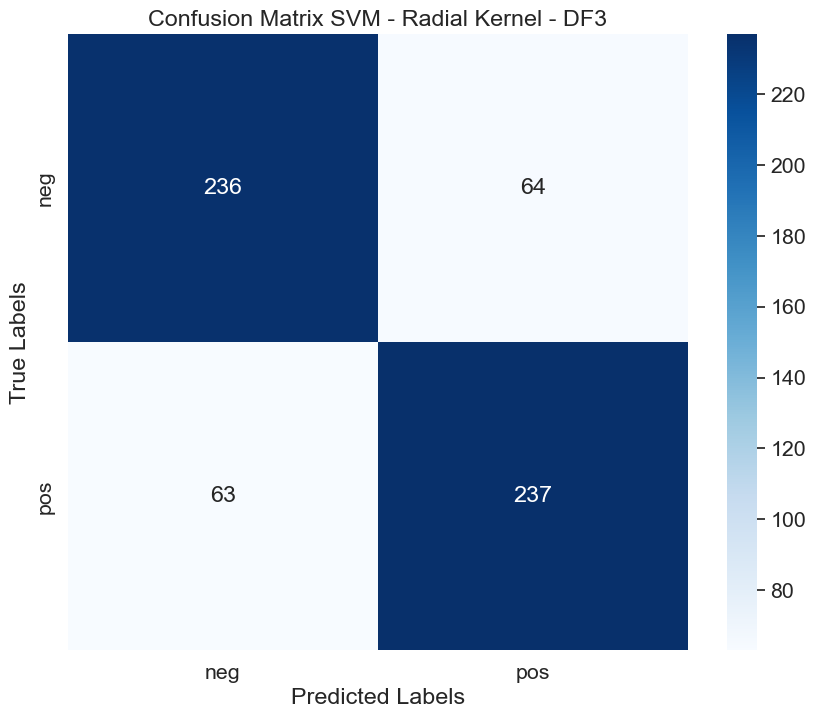

In [134]:

svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(list(X_train3), y_train3)


predictions_linear = svm_classifier.predict(list(X_test3))


accuracy_linear = accuracy_score(y_test3, predictions_linear)
print(f"Linear kernel accuracy: {accuracy_linear}")

confusion_mat_linear = confusion_matrix(y_test3, predictions_linear)
print(f"Linear kernel confusion matrix: {confusion_mat_linear}")

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat_linear, annot=True, fmt='g', cmap='Blues', xticklabels=y_train3.unique(), yticklabels=y_train3.unique())


plt.title('Confusion Matrix SVM - Radial Kernel - DF3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()